### Background functions in flat $\Lambda$CDM cosmology

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate, interpolate
import time

# cosmo packages used
from colossus.cosmology import cosmology
from astropy.cosmology import FlatLambdaCDM
import pyccl

---

In [2]:
rcParams.update({'font.size': 22})

def c_plot(ylabel, zs, res, c_res, res_as=None, res_ccl=None, xscale='linear', yscale='linear'):
    fig, (ax, ay) = plt.subplots(2, 1, figsize=(10, 9), gridspec_kw={'height_ratios': [3, 1]}, constrained_layout=True)
    ax.plot(zs, res, label='colossus')
    if res_as is not None:
        ax.plot(zs, res_as, label='astropy')
    if res_ccl is not None:
        ax.plot(zs, res_ccl, label='pyccl')
    ax.plot(zs, c_res, label='c')
    
    ax.set_xscale(xscale); ax.set_yscale(yscale)
    ax.set_xlim(zs[0], zs[-1])
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'$z$')
    ax.legend()
    
    if res_ccl is not None:
        ay.plot(zs, 100 * (res_ccl / c_res - 1), label='pyccl - c', lw=2)
    if res_as is not None:
        ay.plot(zs, 100 * (res_as / c_res - 1), label='astropy - c')
    ay.plot(zs, 100 * (res / c_res - 1), label='colossus - c')
    
    ay.set_xlim(zs[0], zs[-1])
    ay.set_xscale(xscale)
    ay.set_ylabel(r'$\%$')
    ay.tick_params(axis='x', which='both', labelbottom=False)
    ay.legend(ncol=3, loc='upper left', bbox_to_anchor=(0, 0), fontsize=15)
    
    plt.show()

---

### Setup cosmological parameters

In [3]:
cosmo = cosmology.setCosmology('planck18') # Planck 2018 CMB + BAO
print(cosmo)

Cosmology "planck18" 
    flat = True, Om0 = 0.3111, Ode0 = 0.6888, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.8102, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [4]:
cosmo_as = FlatLambdaCDM(H0=cosmo.H0, Om0=cosmo.Om0, Tcmb0=cosmo.Tcmb0, Neff=cosmo.Neff, Ob0=cosmo.Ob0)

In [5]:
cosmo_ccl = pyccl.Cosmology(Omega_c=(cosmo.Om0-cosmo.Ob0), Omega_b=cosmo.Ob0, h=cosmo.H0/100, n_s=cosmo.ns, sigma8=cosmo.sigma8,
                            Omega_k=0., Neff=cosmo.Neff, T_CMB=cosmo.Tcmb0, w0=-1, wa=0)

---

### Hubble parameter
- Friedmann equation can be rewritten as $E(z) \equiv \frac{H(z)}{H_0} = \sqrt{\Omega_{m,0}(1+z)^3 + \Omega_{\rm rad,0}(1+z)^4 + \Omega_{\Lambda,0}}$
- $\Omega_{\rm rad} = \Omega_\gamma + \Omega_\nu$ : the density of relativistic species, i.e. Photon + Neutrino (assuming negligible mass)

In [6]:
Ogamma0 = cosmo.Ogamma(z=0.)
Onu0 = cosmo.Onu(z=0.)
Or0 = cosmo.Or(z=0.)
print('Ogamma0 = {:.2e}, Onu0 = {:.2e}, Or0 = {:.2e}'.format(Ogamma0, Onu0, Or0))

if False:
    Or0 = 0.
    print('Or0 set to zero')

def c_E(z):
    return np.sqrt(cosmo.Om0*(1+z)**3 + Or0*(1+z)**4 + cosmo.Ode0)

Ogamma0 = 5.40e-05, Onu0 = 3.74e-05, Or0 = 9.14e-05


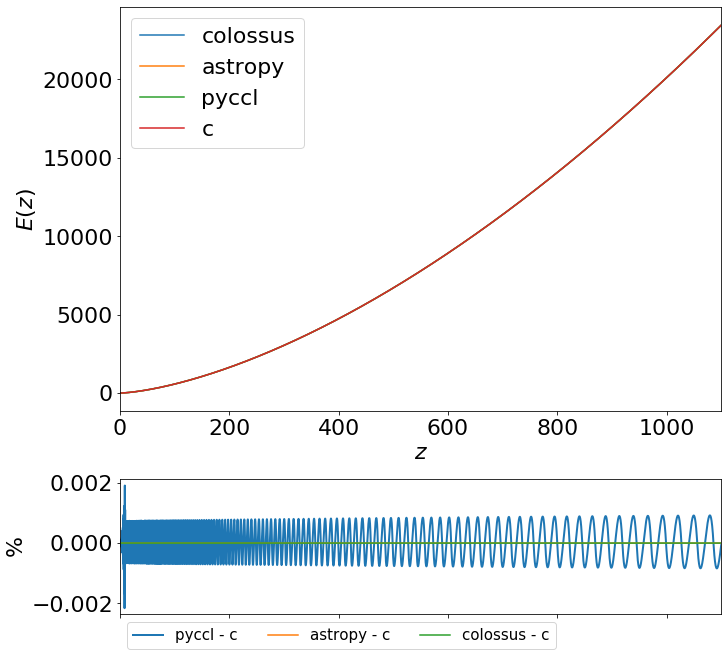

In [7]:
zs = np.arange(0., 1100., 0.1)
z2as = 1 / (1 + zs)

Es = cosmo.Ez(zs)
Es_as = cosmo_as.efunc(zs)
Es_ccl = pyccl.h_over_h0(cosmo_ccl, z2as)
c_Es = c_E(zs)

c_plot(r'$E(z)$', zs, Es, c_Es, res_as=Es_as, res_ccl=Es_ccl)

---

### Comoving radial distance
- $d\chi = c \frac{dz}{H(z)}$
- $\chi(z) = \frac{c}{H_0} \int_0^z dz' \frac{1}{E(z')}$

In [8]:
C_LIGHT = 299792.458 # km/s

def c_chi(z):
    def integrand(zp):
        return 1. / c_E(zp)
    
    return C_LIGHT / cosmo.H0 * integrate.quad(integrand, 0, z)[0]

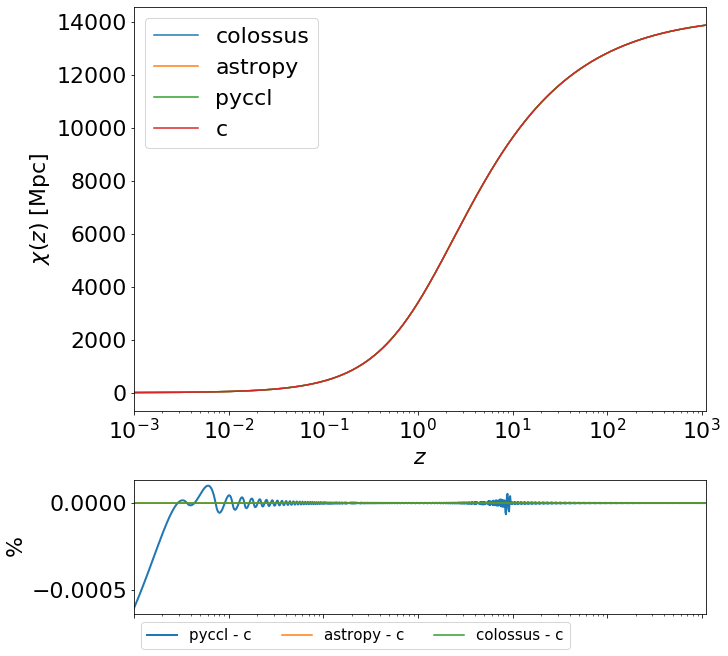

In [9]:
zs = np.logspace(np.log10(0.001), np.log10(1100), 1100)
z2as = 1. / (1. + zs)

chis = cosmo.comovingDistance(z_max=zs) / (cosmo.H0/100.)
chis_as = cosmo_as.comoving_distance(zs).value
chis_ccl = pyccl.comoving_radial_distance(cosmo_ccl, z2as)
c_chis = np.array([c_chi(z_) for z_ in zs])

c_plot(r'$\chi(z)$ [Mpc]', zs, chis, c_chis, res_as=chis_as, res_ccl=chis_ccl, xscale='log')#, yscale='log')

##### Interpolation and inverse process
- Check the accuracy and figure out the proper number of $z$ samples for both chi2z(chi) and z2chi(z) interpolation.

In [10]:
# setup sample points and interpolator
zs = np.concatenate([np.array([0.]), np.logspace(np.log10(0.001), np.log10(1200.), 699)])
chis = cosmo.comovingDistance(zs) / (cosmo.H0/100) # Mpc/h -> Mpc

chi2z_interp = interpolate.interp1d(chis, zs, kind='cubic', bounds_error=False, fill_value='extrapolate')
z2chi_interp = interpolate.interp1d(zs, chis, kind='cubic', bounds_error=False, fill_value='extrapolate')

In [11]:
# test
zs_true = np.logspace(np.log10(0.00001), np.log10(1110.), 4999)
chis_true = cosmo.comovingDistance(zs_true) / (cosmo.H0/100.)

zs_interp1 = chi2z_interp(chis_true)
chis_interp1 = z2chi_interp(zs_true)

# iterate once
zs_interp2 = chi2z_interp(chis_interp1)
chis_interp2 = z2chi_interp(zs_interp1)

# iterate twice
zs_interp3 = chi2z_interp(chis_interp2)
chis_interp3 = z2chi_interp(zs_interp2)

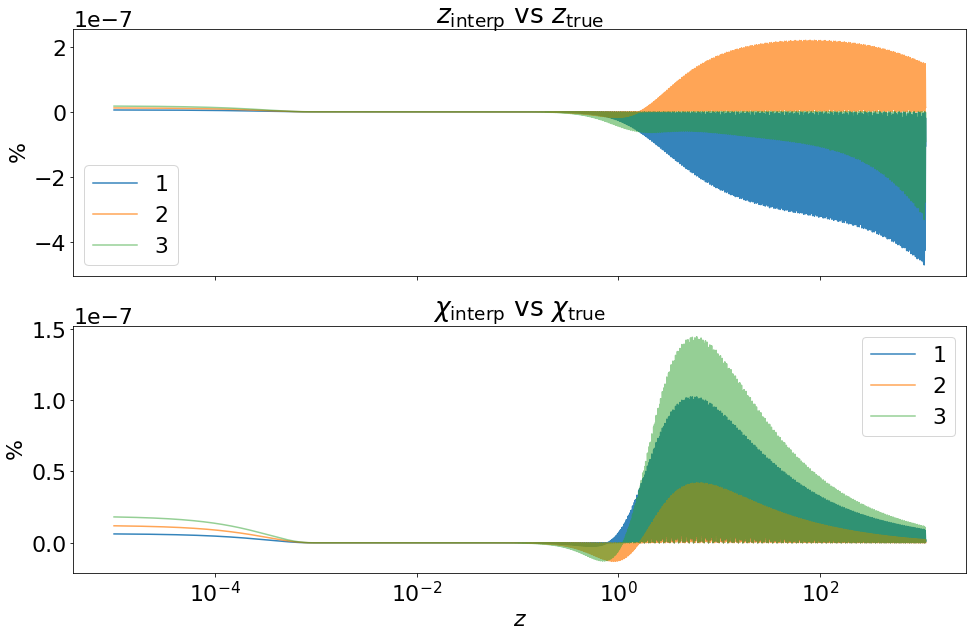

In [12]:
fig, (ax, ay) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

ax.plot(zs_true, 100*(zs_interp1/zs_true-1), label='1', alpha=0.9)
ax.plot(zs_true, 100*(zs_interp2/zs_true-1), label='2', alpha=0.7)
ax.plot(zs_true, 100*(zs_interp3/zs_true-1), label='3', alpha=0.5)
ax.set_ylabel(r'$\%$'); ax.set_title(r'$z_{\rm interp}$ vs $z_{\rm true}$')
ax.legend()


ay.plot(zs_true, 100*(chis_interp1/chis_true-1), label='1', alpha=0.9)
ay.plot(zs_true, 100*(chis_interp2/chis_true-1), label='2', alpha=0.7)
ay.plot(zs_true, 100*(chis_interp3/chis_true-1), label='3', alpha=0.5)
ay.set_ylabel(r'$\%$'); ay.set_title(r'$\chi_{\rm interp}$ vs $\chi_{\rm true}$')
ay.legend()
ay.set_xlabel(r'$z$'); ay.set_xscale('log')

plt.show()

- `log spaced` should be used since $\chi(z)$ grows fast at low $z$ and `linear spaced` would require too many sample points at low $z$ which are useless for high $z$.
- `np.concatenate([np.array([0]), np.logspace(np.log10(0.001), np.log10(1200), 699)])` can keep error lower than $10^{-6}\%$ after $3$ iterations.

---

### Linear growth factor
- At late time: $D(z) = \frac{5}{2}\Omega_{m,0} E(z)\int_z^\infty dz' \frac{1+z'}{E(z')^3}$, which is normalized to $(1+z)^{-1}$ in matter domination.

In [13]:
def c_D(z):
    def integrand(zp):
        return (1. + zp) / c_E(zp)**3
    
    return 5./2.*cosmo.Om0 * c_E(z) * integrate.quad(integrand, z, np.inf)[0]

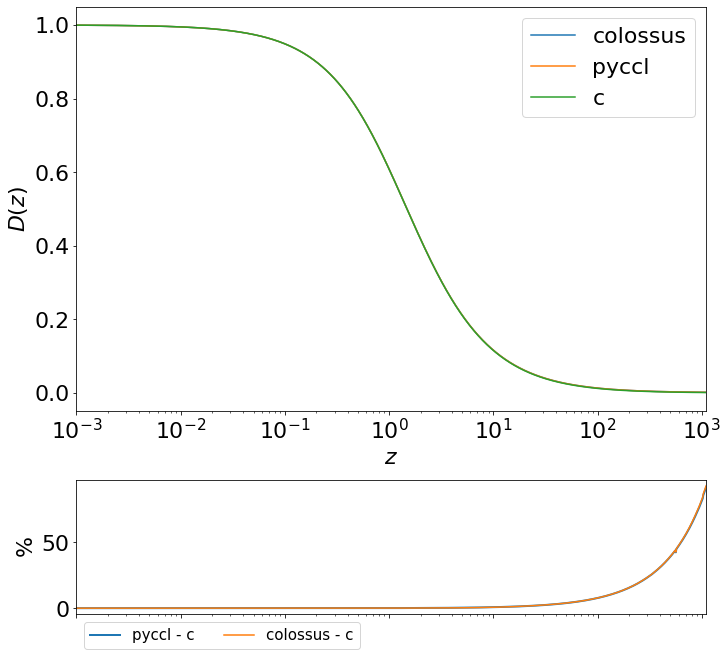

In [14]:
zs = np.logspace(np.log10(0.001), np.log10(1100), 1100)
z2as = 1. / (1. + zs)

Ds = cosmo.growthFactorUnnormalized(zs) / cosmo.growthFactorUnnormalized(0.)
Ds_ccl = pyccl.growth_factor(cosmo_ccl, z2as)
c_Ds = np.array([c_D(z_) for z_ in zs]) / c_D(0)

c_plot(r'$D(z)$', zs, Ds, c_Ds, res_ccl=Ds_ccl, xscale='log')#, yscale='log')

##### Interpolation
- Check the accuracy and figure out the proper number of $z$ samples

In [15]:
# setup sample points and interpolator
zs = np.concatenate([np.array([0.]), np.logspace(np.log10(0.001), np.log10(1200.), 699)])
Ds = cosmo.growthFactorUnnormalized(zs)

z2D_interp = interpolate.interp1d(zs, Ds, kind='cubic', bounds_error=False, fill_value='extrapolate')

In [16]:
# test
zs_true = np.concatenate([np.array([0.]), np.logspace(np.log10(0.00001), np.log10(1110.), 4999)])
Ds_true = cosmo.growthFactorUnnormalized(zs_true)

Ds_interp = z2D_interp(zs_true)

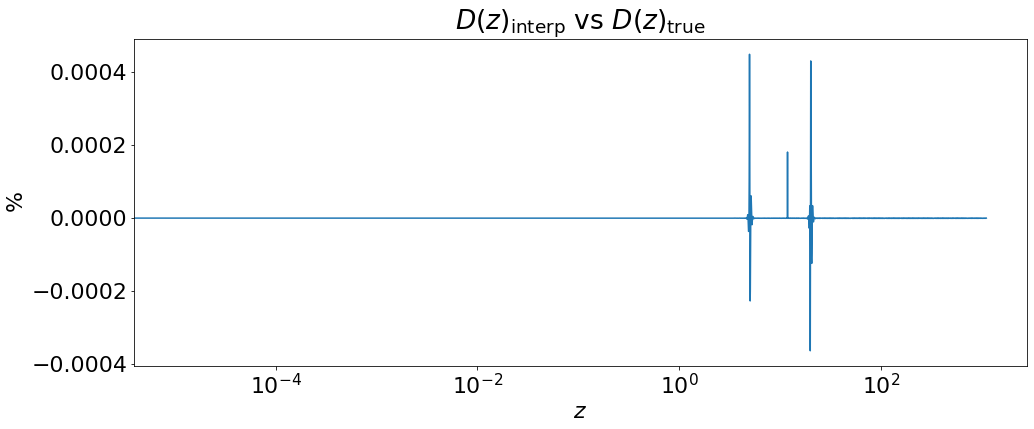

In [17]:
fig, (ax) = plt.subplots(1, 1, figsize=(16, 6))

ax.plot(zs_true, 100*(Ds_interp/Ds_true-1))

ax.set_ylabel(r'$\%$'); ax.set_title(r'$D(z)_{\rm interp}$ vs $D(z)_{\rm true}$')
ax.set_xlabel(r'$z$'); ax.set_xscale('log')

plt.show()

- Similar as interpolation for $\chi(z)$, `np.concatenate([np.array([0]), np.logspace(np.log10(0.001), np.log10(1200), 699)])` can keep error lower than $10^{-3}\%$.

---